In [2]:
import pandas as pd
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style("ticks")

Olist conducted an experiment to see if altering the delivery estimation could result in higher review scores.

# Generate random data for A/B testing

In [3]:
date_range = pd.date_range(start="2018-07-01", end="2018-09-01")

In [4]:
date_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
               '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
               '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
               '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
               '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
      

In [5]:
np.datetime64("2018-07-15")

numpy.datetime64('2018-07-15')

In [6]:
control = {1: 10,
           2: 3,
           3: 8,
           4: 20,
           5: 59}

test = {1: 10,
        2: 2,
        3: 10,
        4: 22,
        5: 63}

def generate_review_distribution(freq_dict):
    l = []
    for key, value in freq_dict.items():
        l += [key] * value
    return l

In [7]:
def get_random_review(date, group):
    if (group == 102) & (date >= np.datetime64("2018-07-15")):
        random_reviews = generate_review_distribution(test)
    else:
        random_reviews = generate_review_distribution(control)
    return random.choice(random_reviews)
    
def generate_random_observation(date, group):
    return str(uuid.uuid4()), get_random_review(date, group)

In [32]:
# create list of dicts to later on convert to a dataframe
rows = []
for date in date_range:
    # two groups
    for group in [101,102]:
        # pick a random number of orders btw 350 and 450
        orders = random.choice(range(350,450))
        for obs in range(orders):
            order_id, review_score = generate_random_observation(date, group)
            rows.append({"date_id": date,
                         "experiment_id": group,
                         "order_id": order_id,
                         "review_score": review_score})
            
df = pd.DataFrame(rows)

### Plot data and calculate means

In [39]:
#df.loc[df["experiment_id"]==100]
#check and see what experiment_id 100 is from

,date_id,experiment_id,order_id,review_score


In [40]:
df.head()

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,daf98958-e883-4480-b4c1-856291d33168,4
1,2018-07-01,101,e294066f-e859-4326-ad1f-a993047a999e,4
2,2018-07-01,101,3d2a58df-dfad-4fd5-887d-f409171c2e06,5
3,2018-07-01,101,654857c3-be8f-4431-8065-b83e4b5a0e31,4
4,2018-07-01,101,dc73aee0-cdb6-49bb-acad-5437022cdd32,1


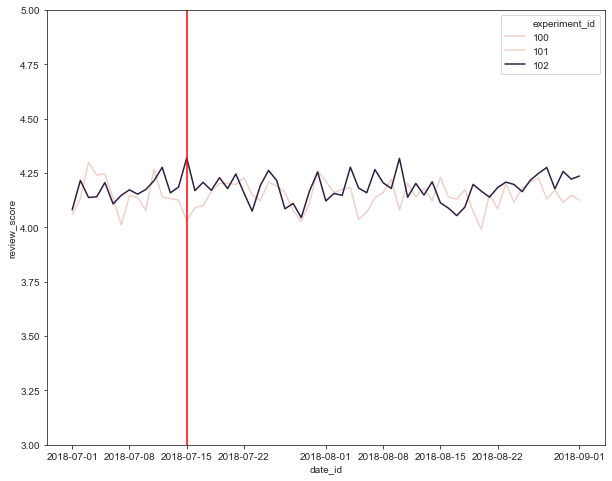

In [33]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df.groupby(["date_id", "experiment_id"]).mean().reset_index(),
             x="date_id",
             y="review_score",
             hue="experiment_id",
             ax=ax);
ax.axvline("2018-07-15", color="r")
ax.set_ylim(3,5);

In [41]:
df[df["date_id"] >= "2018-07-15"].groupby("experiment_id").mean()

,review_score
experiment_id,
101,4.146837
102,4.184788


In [35]:
#df.to_csv("data/olist_experiment_data.csv")

In [3]:
df = (pd.read_csv("data/olist_experiment_data.csv")
      .drop(columns="Unnamed: 0"))
df["date_id"] = pd.to_datetime(df["date_id"])

In [4]:
df.head()

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,daf98958-e883-4480-b4c1-856291d33168,4
1,2018-07-01,101,e294066f-e859-4326-ad1f-a993047a999e,4
2,2018-07-01,101,3d2a58df-dfad-4fd5-887d-f409171c2e06,5
3,2018-07-01,101,654857c3-be8f-4431-8065-b83e4b5a0e31,4
4,2018-07-01,101,dc73aee0-cdb6-49bb-acad-5437022cdd32,1


How do we know if this difference did not just occure by chance?
We have uncertainty because we are looking at a sample and want to generalize to all users.


We use statistics => t-test

Use the Welch's t-test (two independent samples, unequal sample sizes, unequal variance) (Heteroskedasticty)

In [5]:
df_e = df.loc[df["date_id"] >= "2018-07-15"]

group_a = df_e.loc[df["experiment_id"] == 101, "review_score"]
group_b = df_e.loc[df["experiment_id"] == 102, "review_score"]

In [6]:
len(group_a)

19491

In [7]:
len(group_b)

19590

In [8]:
t,p = scipy.stats.ttest_ind(group_a, group_b, equal_var=False)

In [9]:
p

0.0031660921355939507

In [10]:
print(f"the p-value is {round(p*100, 3)}%")

the p-value is 0.317%


In [11]:
print(f"the t-statistic is {round(t,3)}")

the t-statistic is -2.951


## What the *$&% if the p-value?

# Central Limit Theorem

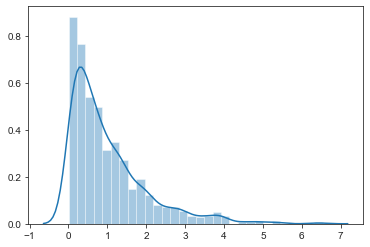

In [12]:
sns.distplot(np.random.exponential(size=1000));

In [13]:
sample_1 = np.random.exponential(size=1000)

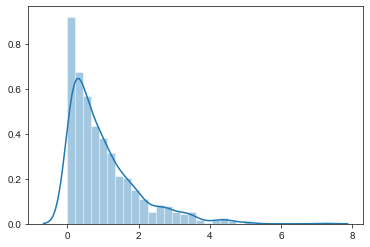

In [14]:
sns.distplot(sample_1);

In [15]:
sample_1.mean()

0.9991669027374164

In [16]:
sample_2 = np.random.exponential(size=1000)
sample_2.mean()

1.0385864061402035

In [17]:
sample_3 = np.random.exponential(size=1000)
sample_3.mean()

1.0149538064967842

In [18]:
def plot_hist(n_samples, sample_size, ax):
    sample_means = [(np.random.exponential(size=sample_size)).mean() for i in range(n_samples)]
    sns.distplot(sample_means, ax=ax)

In [19]:
plot_hist(n_samples=1000, sample_size=500)

TypeError: plot_hist() missing 1 required positional argument: 'ax'

Tweak the sample size parameter and check its influence on the shape

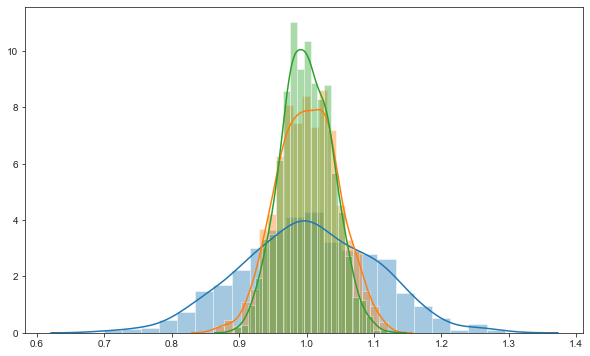

In [20]:
fig,ax = plt.subplots(figsize=(10,6))

plot_hist(n_samples=1000, sample_size=100, ax=ax)
plot_hist(n_samples=1000, sample_size=500, ax=ax)
plot_hist(n_samples=1000, sample_size=700, ax=ax)

Tweak the number of samples you are taking and check its influence on the shape

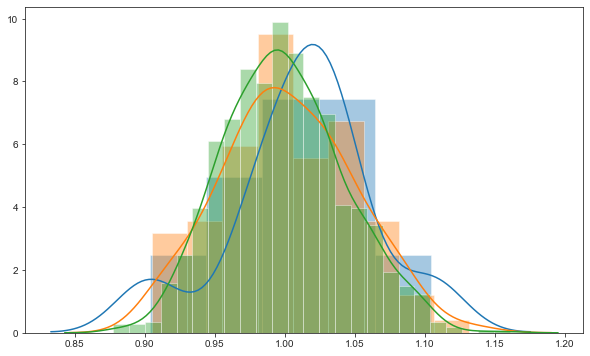

In [21]:
fig,ax = plt.subplots(figsize=(10,6))

plot_hist(n_samples=10, sample_size=500, ax=ax)
plot_hist(n_samples=100, sample_size=500, ax=ax)
plot_hist(n_samples=1000, sample_size=500, ax=ax)

# Analysis
Testing the hypothesis: 

Null Hypothesis: 

$H_0 : avg\_score_{control} = avg\_score_{test}$

<=> $H_0 : avg\_score_{control} - avg\_score_{test} = 0$

Against the alternative hypothesis: 

$H_1 : avg\_score_{control} - avg\_score_{test} \neq 0$

-> The treatment had a non-zero impact: The overestimation of delivery_days had an impact on review_score


In [22]:
df.head()

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,daf98958-e883-4480-b4c1-856291d33168,4
1,2018-07-01,101,e294066f-e859-4326-ad1f-a993047a999e,4
2,2018-07-01,101,3d2a58df-dfad-4fd5-887d-f409171c2e06,5
3,2018-07-01,101,654857c3-be8f-4431-8065-b83e4b5a0e31,4
4,2018-07-01,101,dc73aee0-cdb6-49bb-acad-5437022cdd32,1


In [23]:
df_exp = df[df["date_id"]>= "2018-07-15"].copy()

In [24]:
means = df_exp.groupby("experiment_id").mean()
means

,review_score
experiment_id,
101,4.146837
102,4.184788


In [25]:
var = df_exp.groupby("experiment_id").var()
var

,review_score
experiment_id,
101,1.682696
102,1.548066


In [26]:
stds = df_exp.groupby("experiment_id").std()
stds

,review_score
experiment_id,
101,1.297188
102,1.244213


In [27]:
ssize = df_exp.groupby("experiment_id").size()
ssize

experiment_id
101    19491
102    19590
dtype: int64

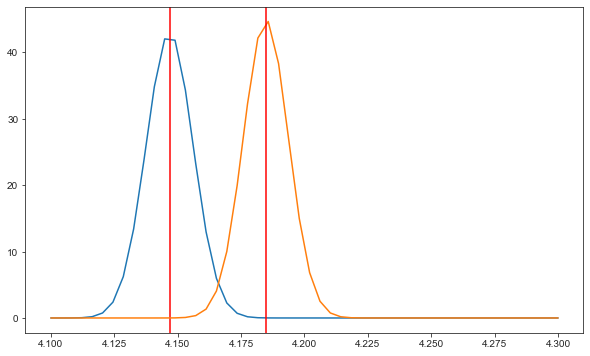

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(4.1, 4.3)

std_a = stds.loc[101, "review_score"] / np.sqrt(ssize[101])
pdf_a = scipy.stats.norm.pdf(x, 
                             means.loc[101, "review_score"], 
                             std_a)
plt.plot(x, pdf_a);
ax.axvline(means.loc[101, "review_score"], color="r");

std_b = stds.loc[102, "review_score"] / np.sqrt(ssize[102])
pdf_b = scipy.stats.norm.pdf(x, 
                             means.loc[102, "review_score"], 
                             std_b)
plt.plot(x, pdf_b);
ax.axvline(means.loc[102, "review_score"], color="r");

In [29]:
combined_standard_error = np.sqrt(var.loc[101, "review_score"]/ssize[101] + var.loc[102, "review_score"]/ssize[102])

In [30]:
combined_standard_error

0.012859053235181094

In [33]:
diff_mean = means.loc[101, "review_score"] - means.loc[102, "review_score"]

In [34]:
diff_mean

-0.03795115552998407

In [35]:
np.linspace(-.1, .1)

array([-0.1       , -0.09591837, -0.09183673, -0.0877551 , -0.08367347,
       -0.07959184, -0.0755102 , -0.07142857, -0.06734694, -0.06326531,
       -0.05918367, -0.05510204, -0.05102041, -0.04693878, -0.04285714,
       -0.03877551, -0.03469388, -0.03061224, -0.02653061, -0.02244898,
       -0.01836735, -0.01428571, -0.01020408, -0.00612245, -0.00204082,
        0.00204082,  0.00612245,  0.01020408,  0.01428571,  0.01836735,
        0.02244898,  0.02653061,  0.03061224,  0.03469388,  0.03877551,
        0.04285714,  0.04693878,  0.05102041,  0.05510204,  0.05918367,
        0.06326531,  0.06734694,  0.07142857,  0.0755102 ,  0.07959184,
        0.08367347,  0.0877551 ,  0.09183673,  0.09591837,  0.1       ])

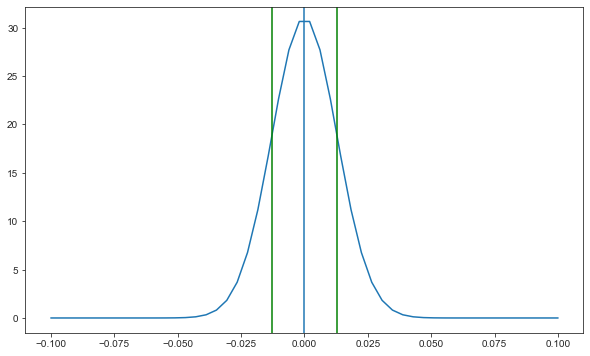

In [41]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(-.1, .1)
pdf_c = scipy.stats.norm.pdf(x,
                             0, 
                             combined_standard_error)
plt.plot(x, pdf_c);
ax.axvline(0);
ax.axvline(0.0128, color="g");
ax.axvline(-0.0128, color="g");

In [38]:
t = diff_mean / combined_standard_error
t

-2.9513180197554103

In [42]:
scipy.stats.ttest_ind(df_exp.loc[df_exp["experiment_id"]== 101, "review_score"], 
                      df_exp.loc[df_exp["experiment_id"]== 102, "review_score"], 
                      equal_var=False)

Ttest_indResult(statistic=-2.9513180197554125, pvalue=0.0031660921355939507)

Applying an alpha-level of 5% (significance leve), we reject the null hypothesis that the mean of both samples are equal. Hence, that the chnge we introduced (treatment) has had a statistically significant impact on the average review_score. The effect size is estimated to be approximately 0.038, resulting in an increase of average review_scores from 4.14 to 4.18.  

## Interpreting the p-value

Given our samples, assuming the null hypothesis, the likelyhood of obtaining the difference that we observed or more extreme is 0.0031. 

Generally = Given the data, assuming the null hypothesis is true, how likely is it that we obtain the value we observed or more extreme. 

How ridiculous is the null hypothesis?? 